![logo](https://climate.copernicus.eu/sites/default/files/2025-03/logoline_c3s.png)

# Tutorial on climatologies using climate data from C3S

**This notebook can be run on free online platforms, such as Binder, Kaggle and Colab, or they can be accessed from GitHub. The links to run this notebook in these environments are provided here, but please note they are not supported by ECMWF.**

[![binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/ecmwf-training/c3s-training-submodule-reanalysis/main?labpath=reanalysis-climatology.ipynb)
[![kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-training/c3s-training-submodule-reanalysis/blob/main/reanalysis-climatology.ipynb)
[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ecmwf-training/c3s-training-submodule-reanalysis/blob/main/reanalysis-climatology.ipynb)
[![github](https://img.shields.io/badge/Open%20in-GitHub-black?logo=github)](https://github.com/ecmwf-training/c3s-training-submodule-reanalysis/blob/main/reanalysis-climatology.ipynb)

![logo](./img/climatology_banner.png)

## Learning objectives 🎯

In this tutorial we will access data from the Climate Data Store (CDS) of the Copernicus Climate Change Service (C3S), and analyse climatologies and trends in near-surface air temperature. The tutorial comprises the following steps:

- Calculate a climate normal
- Visualise anomalies with respect to the normal
- Calculate monthly climatology and anomalies
- View time series and analyse trends

## Prepare your environment

### Set up the CDSAPI and your credentials

The code below will ensure that the `cdsapi` package is installed. If you have not setup your `~/.cdsapirc` file with your credenials, you can replace `None` with your credentials that can be found on the [how to api](https://cds.climate.copernicus.eu/how-to-api) page (you will need to log in to see your credentials).

In [1]:
!pip install -q cdsapi
# If you have already setup your .cdsapirc file you can leave this as None
cdsapi_key = None
cdsapi_url = None

### (Install and) Import libraries

We will be working with data in NetCDF format. To best handle this data we will use libraries for working with multidimensional arrays, in particular Xarray. We will also need libraries for plotting and viewing data, in this case we will use Matplotlib and Cartopy.

In [2]:
# CDS API
import cdsapi

# Libraries for working with multidimensional arrays
import numpy as np
import xarray as xr

# Library for interacting with the operating system
import os

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

# Disable warnings for data download via API
import urllib3 
urllib3.disable_warnings()

### Specify data directory

In [3]:
# Directory to store data
# Please ensure that data_dir is a location where you have write permissions
DATADIR = './data_dir/'
# Create this directory if it doesn't exist
os.makedirs(DATADIR, exist_ok=True)

## Explore data

To search for data, visit the CDS website: http://cds.climate.copernicus.eu.
Here you can search for ERA5 data using the search bar. The data we need for this tutorial is the [ERA5 monthly averaged data on single levels from 1979 to present](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=overview). ERA5 is the 5th version of the ECMWF Reanalysis dataset. Reanalysis uses a state of the art forecast model and data assimilation system to create a consistent "map without gaps" of observed and modelled climate variables over the past decades.

### Search for the data

Having selected the correct dataset, we now need to specify what product type, variables, temporal and geographic coverage we are interested in. These can all be selected in the **"Download data"** tab. In this tab a form appears in which we will select the following parameters to download:

:::{dropdown} Parameters of data to download


- Product type: `Monthly averaged reanalysis`
- Variable: `2m temperature`
- Year: `1979 to year before present`
- Month: `all`
- Time: `00:00` (default)
- Geographical area: `Europe` 
- Format: `NetCDF`

:::

At the end of the download forms, select "Show API request". This will reveal a block of code, which you can simply copy and paste into a cell of your Jupyter Notebook (see cell below). Having copied the API request into the cell below, running this will retrieve and download the data you requested into your local directory.

:::{warning}

Please remember to accept the terms and conditions of the dataset, at the bottom of the CDS download form!

:::

### Download the data

With the API request copied into the cell below, running this cell will retrieve and download the data you requested into your local directory.

In [4]:
c = cdsapi.Client()
c.retrieve(
    'reanalysis-era5-single-levels-monthly-means',
    {
        'product_type': 'monthly_averaged_reanalysis',
        'variable': '2m_temperature',
        'year': [
            '1979', '1980', '1981',
            '1982', '1983', '1984',
            '1985', '1986', '1987',
            '1988', '1989', '1990',
            '1991', '1992', '1993',
            '1994', '1995', '1996',
            '1997', '1998', '1999',
            '2000', '2001', '2002',
            '2003', '2004', '2005',
            '2006', '2007', '2008',
            '2009', '2010', '2011',
            '2012', '2013', '2014',
            '2015', '2016', '2017',
            '2018', '2019', '2020',
        ],
        'month': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
        ],
        'time': '00:00',
        'area': [
            72, -25, 34,
            40,
        ],
        'data_format': 'netcdf_legacy',
    },
    f'{DATADIR}era5_monthly_t2m_eur.nc')

2025-07-10 11:50:19,059 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-10 11:50:19,472 INFO Request ID is b26f4dc9-5e98-449f-bc41-8251e61710ee
2025-07-10 11:50:19,548 INFO status has been updated to accepted
2025-07-10 11:50:41,289 INFO status has been updated to successful


c378070ecb35ff743feba167766d88da.nc:   0%|          | 0.00/38.4M [00:00<?, ?B/s]

'./data_dir/era5_monthly_t2m_eur.nc'

### Inspect data

Now that we have downloaded the data, we can inspect it. We have requested the data in NetCDF format. This is a commonly used format for array-oriented scientific data. To read and process this data we will make use of the [Xarray](http://xarray.pydata.org/en/stable/) library. Xarray is an open source project and Python package that makes working with labelled multi-dimensional arrays simple and efficient. We will read the data from our NetCDF file into an [xarray.Dataset](https://xarray.pydata.org/en/stable/generated/xarray.Dataset.html).

In [5]:
t2m = f'{DATADIR}era5_monthly_t2m_eur.nc'

In [6]:
# Create Xarray Dataset
ds = xr.open_dataset(t2m)

Now we can query our newly created Xarray dataset ...

In [7]:
ds

<xarray.Dataset> Size: 161MB
Dimensions:    (longitude: 261, latitude: 153, time: 504)
Coordinates:
  * longitude  (longitude) float32 1kB -25.0 -24.75 -24.5 ... 39.5 39.75 40.0
  * latitude   (latitude) float32 612B 72.0 71.75 71.5 71.25 ... 34.5 34.25 34.0
  * time       (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2020-12-01
Data variables:
    t2m        (time, latitude, longitude) float64 161MB ...
Attributes:
    Conventions:  CF-1.6
    history:      2025-07-09 16:17:48 GMT by grib_to_netcdf-2.41.0: grib_to_n...

We see that the dataset has one variable called **"t2m"**, which stands for "2 metre temperature", and three coordinates of **longitude**, **latitude** and **time**.

### Convert longitude to [-180, 180] grid

Notice that the `longitude` variables in the Xarray Dataset and Data Array objects are in the range of `[0, 359.75]`. By default, ECMWF data are on a [0, 360] grid. Should you wish to, there are two options to bring the longitude coordinates to a `[-180, 180]` grid. The first option, in case you already have the data downloaded, is to assign values to coordinates with the xarray function `assign_coords()`. The code below shifts your longitude coordinates from `[0, 359.75]` to `[-180, 179.75]`.

The second option is to specify the `area` keyword argument right when you request data with the `CDS API`. The `area` keyword then automatically reprojects the requested data onto a [-180, 180] grid.

In [8]:
ds_180 = ds.assign_coords(longitude=(((ds.longitude + 180) % 360) - 180)).sortby('longitude')

While an Xarray **dataset** may contain multiple variables, an Xarray **data array** holds a single multi-dimensional variable and its coordinates. To make the processing of the **t2m** data easier, we convert in into an Xarray data array.

In [9]:
# Create Xarray Data Array
da = ds_180['t2m']

Let's view this data:

In [10]:
da

<xarray.DataArray 't2m' (time: 504, latitude: 153, longitude: 261)> Size: 161MB
[20126232 values with dtype=float64]
Coordinates:
  * latitude   (latitude) float32 612B 72.0 71.75 71.5 71.25 ... 34.5 34.25 34.0
  * time       (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2020-12-01
  * longitude  (longitude) float32 1kB -25.0 -24.75 -24.5 ... 39.5 39.75 40.0
Attributes:
    units:      K
    long_name:  2 metre temperature

### Change temperature units from Kelvin to Celsius

Notice that the ERA-5 temperature data are in units of `Kelvin`, the base unit for temperature in the International System of Units (SI). If you want to convert the values from `Kelvin` to `degrees Celsius`, you have to subtract 273.15.

In [11]:
da_degc = da - 273.15

If you inspect the characteristics of the data above, you see that when you convert the data values, the data array's Attributes are dropped. However, we want to keep the information provided by the Attributes and for this reason, we re-assign the attributes from the previous, unconverted object with the function assign_attrs(). Since the unit has changed, we assign a new unit measure to the units attribute.

In [12]:
da_degc = da_degc.assign_attrs(da.attrs)
da_degc.attrs['units'] = '° C'

### Plot data

Now, let us visualize one time step to get a better idea of the data. xarray offers built-in matplotlib functions that allow you to plot a `DataArray`. With the function `plot()`, you can easily plot e.g. the first time step of the loaded array.

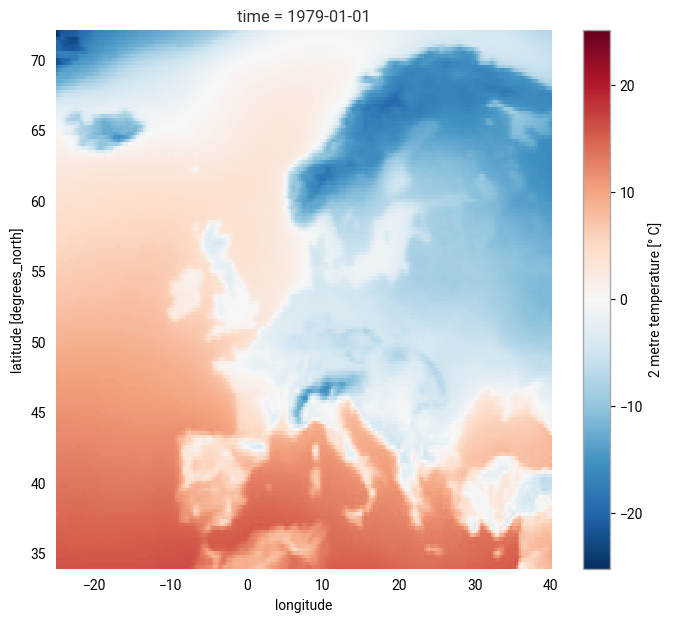

In [13]:
da_degc[0,:,:].plot()

An alternative to the built-in xarray plotting functions is to make use of a combination of the plotting libraries [matplotlib](https://matplotlib.org/) and [Cartopy](https://scitools.org.uk/cartopy/docs/latest/). One of Cartopy's key features is its ability to transform array data into different geographic projections. In combination with matplotlib, it is a very powerful way to create high-quality visualisations and animations. In later plots, we will make use of these libraries to produce more customised visualisations.

## Calculate climate normals

### Standard reference period and climate normals

Anthropogenic activities and natural variations from years to decades shape the Earth's climate. In order to evaluate anomalous conditions of a specific month or year, the World Meteorological Organization (WMO) defines `standard reference periods` used to create `climate normals`. `Climate normals` can be considered as the typical climate for the period the normals are based on.

Until 2020, the most current and widely used standard reference period was the 30-year range of 1981-2010. With the start of 2021, the WMO recommended updating the climate normal reference period to the range 1991-2020.

First, let us calculate the near-surface air temperature climate normal for the reference period 1991-2020. For this, we will create for each year the average near-surface air temperature. You can use the xarray function `groupby()` to group the data by year (specify `time.year`) and then to create the average of each year with the function `mean()`. The resulting object contains for each year from 1979 to 2020 the average annual global mean surface air temperature.

In [14]:
yearly_mean = da_degc.groupby('time.year').mean(keep_attrs=True)

From the data array object above, we can then filter the years of the reference period with the function `where()`. Inside the function, you can filter on the data dimensions. In the example below, we will apply a filter to keep data for all years in the range 1991 to 2020.

In [15]:
ref = yearly_mean.where((yearly_mean.year > 1990) & (yearly_mean.year < 2021), drop=True)

In a last step, we want to create the average of the yearly-mean near-surface air temperature for the reference period 1991-2020. We can do this by applying the function `mean()` and specify the dimension `year` as the dimension to be averaged. The resulting data array is left with two dimensions, latitude and longitude.

In [16]:
ref_mean = ref.mean(dim="year", keep_attrs=True)

## Anomaly calculation

The next step is now to calculate the anomaly of a specific year with respect to the climate normal. The term anomaly refers to the deviation of a value from the long-term average. Positive or negative anomalies indicate that the average temperatures of a particular year were respectively warmer or cooler than the reference value.

Let us calculate the near-surface air temperature anomaly for the year 2016. In a first step, we select the average near-surface temperature values for the year 2016 from the xarray.DataArray object `yearly_mean`. With the xarray function `sel()`, you can select a data array based on coordinate labels. The coordinate label of interest is `year=2016`.

In [17]:
t2m_2016 = yearly_mean.sel(year=2016)

Next, we calculate the near-surface air temperature anomaly for 2016 by subtracting the climate normal (i.e. the reference near-surface air temperature values) from the average near-surface air temperature for 2016.

In [18]:
anom_2016 = t2m_2016 - ref_mean

Let's visualize the global near-surface air temperature anomaly for 2016 to see which regions were warmer or cooler compared to the reference period. This time we will make use of a combination of the plotting libraries [matplotlib](https://matplotlib.org/) and [Cartopy](https://scitools.org.uk/cartopy/docs/latest/) to create a more customised figure. One of Cartopy's key features is its ability to transform array data into different geographic projections. In combination with matplotlib, it is a very powerful way to create high-quality visualisations and animations.

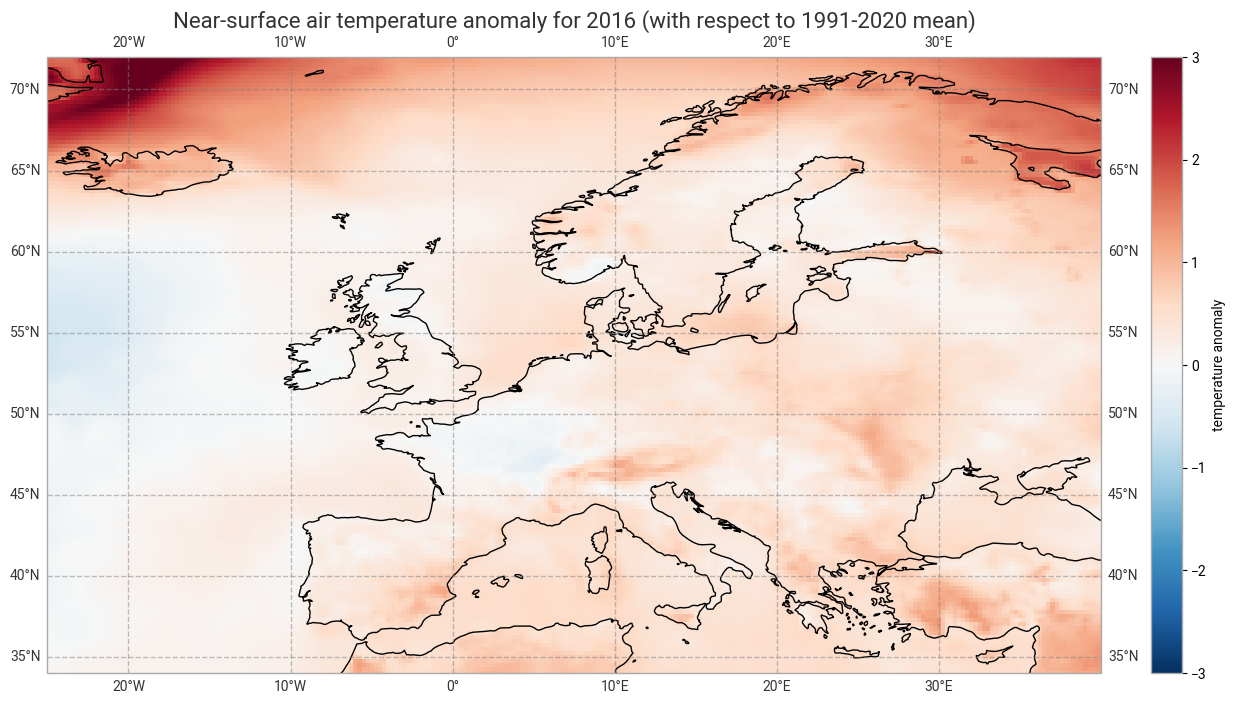

In [19]:
# create the figure panel and the map using the Cartopy PlateCarree projection
fig, ax = plt.subplots(1, 1, figsize = (16, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the data
im = plt.pcolormesh(anom_2016.longitude, anom_2016.latitude, anom_2016, cmap='RdBu_r', vmin=-3, vmax=3) 

# Set the figure title, add lat/lon grid and coastlines
ax.set_title('Near-surface air temperature anomaly for 2016 (with respect to 1991-2020 mean)', fontsize=16)
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--') 
ax.coastlines(color='black')
ax.set_extent([-25, 40, 34, 72], crs=ccrs.PlateCarree())

# Specify the colourbar
cbar = plt.colorbar(im,fraction=0.05, pad=0.04)
cbar.set_label('temperature anomaly') 

# Save the figure
fig.savefig(f'{DATADIR}ERA5_global_2016_anomaly_eur.png')

## Calculate monthly climatology and anomalies

We will now calculate the monthly climatology of near-surface air temperature for the period 1991 to 2020. We will also view the anomalies with respect to the climatology for a particular month. To do this, we return to the data array created at the end of [section 1](#search_download).

We first create again a temporal subset for the period 1991 to 2020, but this time keeping the monthly temporal resolution.

In [20]:
clim_period = da_degc.sel(time=slice('1991-01-01', '2020-12-01'))

We will now calculate the monthly climatology by first applying the function `groupby()` to group the data array by month and then calculating the average for each monthly group. The resulting data array is the monthly climatology for air temperature in Europe based on the reference period 1991 to 2020.

In [21]:
clim_month = clim_period.groupby('time.month').mean()

Let us view this monthly climatology averaged over the entire European region. To do this we need to average over the latitude and longitude dimensions. A very important consideration however is that the gridded data cells do not all correspond to the same areas. The size covered by each data point varies as a function of latitude. We need to take this into account when averaging. One way to do this is to use the cosine of the latitude as a proxy for the varying sizes.

First, we calculate the weights by using the cosine of the latitude, then we apply these weights to the data array with the xarray function `weighted()`.

In [22]:
weights = np.cos(np.deg2rad(clim_month.latitude))
weights.name = "weights"
clim_month_weighted = clim_month.weighted(weights)

The next step is to compute the mean across the latitude and longitude dimensions of the weighted data array with the function `mean()`.

In [23]:
mean = clim_month_weighted.mean(["longitude", "latitude"])

This data array now gives us the monthly climatology of Europe for the period 1991 to 2020. We could create a simple plot of this:

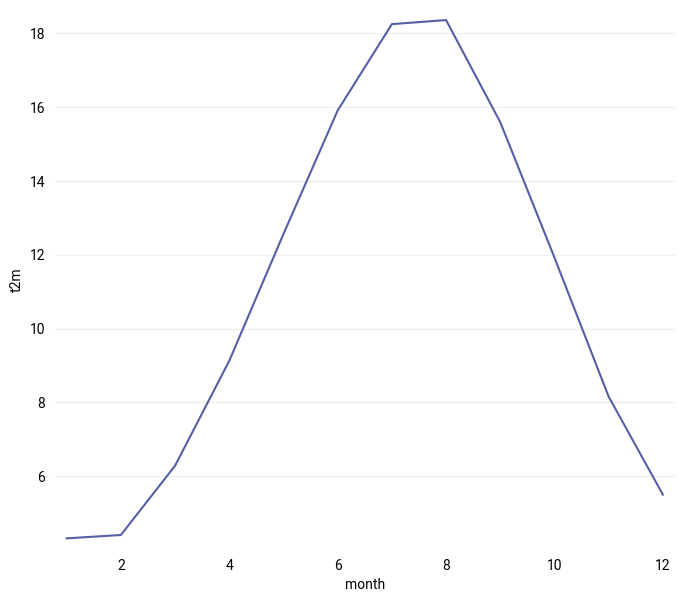

In [24]:
mean.plot()

One more step we can take is to repeat the process above for the standard deviation, to enable us to plot both in a single figure.

In [25]:
clim_std = clim_period.groupby('time.month').std()

weights = np.cos(np.deg2rad(clim_std.latitude))
weights.name = "weights"
clim_std_weighted = clim_std.weighted(weights)

std = clim_std_weighted.mean(["longitude", "latitude"])

We can now plot the European monthly climatology and standard deviation in a figure:

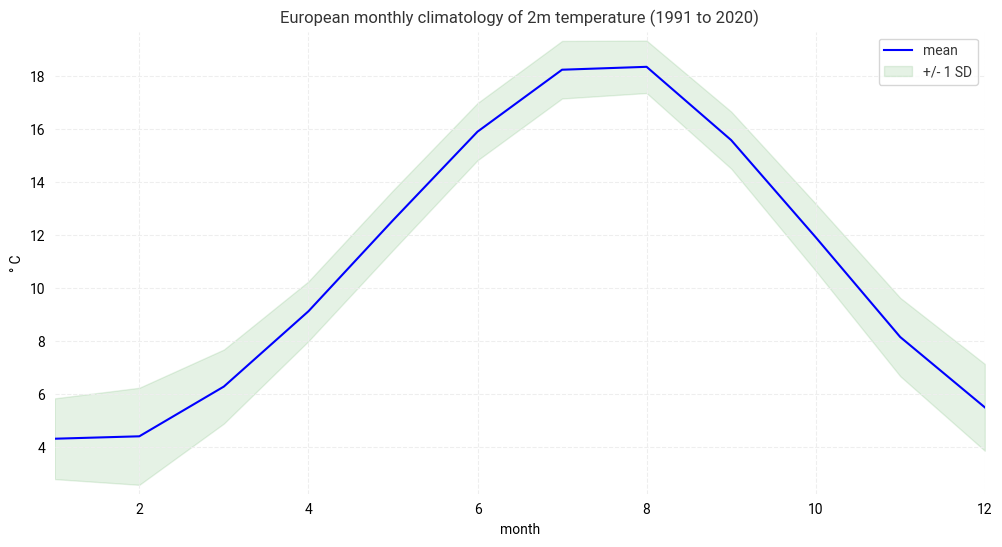

In [26]:
fig, ax = plt.subplots(1, 1, figsize = (12, 6))

ax.plot(mean.month, mean, color='blue', label='mean')
ax.fill_between(mean.month, (mean + std), (mean - std), alpha=0.1, color='green', label='+/- 1 SD')

ax.set_title('European monthly climatology of 2m temperature (1991 to 2020)')
ax.set_ylabel('° C')
ax.set_xlabel('month')
ax.set_xlim(1,12)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
ax.grid(linestyle='--')

fig.savefig(f'{DATADIR}Eur_monthly_t2m_clim.png')

### Calculate monthly anomalies

We will now inspect monthly anomalies with respect to this climatology. We will return to the data that we created prior to aggregating by latitude and longitude. We can compute the monthly anomalies for each month of our original European time series by subtracting from it the monthly climatology. Important to mention here is to first group by `time.month`. In this way, xarray understands to use the correct value of the monthly climatology to calculate the anomalies.

In [27]:
anom_month = da_degc.groupby('time.month') - clim_month

### Visualise European near-surface temperature anomalies for one specific month

The last step is to visualize the air temperature anomaly field in Europe for one specific month. In Europe, 2020 was the hottest year on record and the northwest has expierenced a heatwave during the second half of July and first half of August. Let us select the air temperature anomalies for August for each year from 1979 to 2020. Through the grouping process, the data array `anom_month` has `month` as additional coordinate information. Based on this coordinate information, you can specify that you only want to select the data array entries for August (month = 8).

In [28]:
anom_aug = anom_month[anom_month.month == 8]

Now let us visualise the near-surface air temperature anomaly for Europe in August 2020. Again we make use of the function `visualize_pcolormesh`.

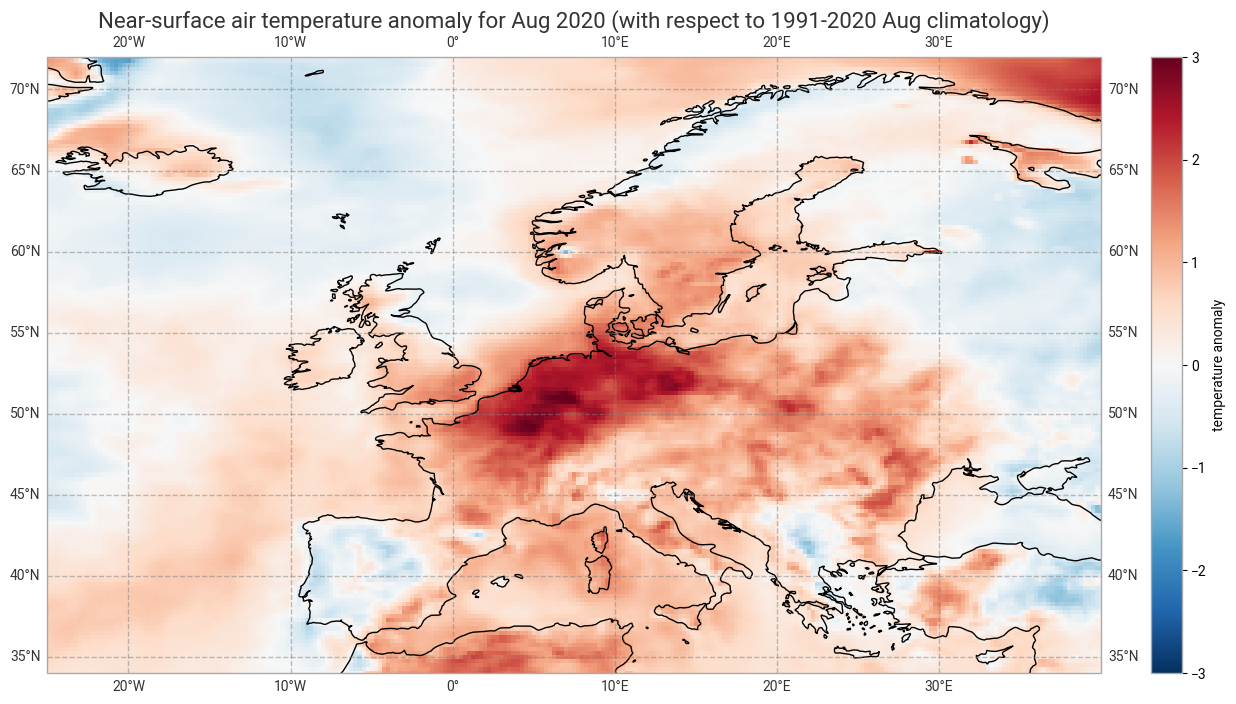

In [29]:
fig, ax = plt.subplots(1, 1, figsize = (16, 8), subplot_kw={'projection': ccrs.PlateCarree()})

im = plt.pcolormesh(anom_aug.longitude, anom_aug.latitude, anom_aug[41,:,:], cmap='RdBu_r', vmin=-3, vmax=3) 

ax.set_title('Near-surface air temperature anomaly for Aug 2020 (with respect to 1991-2020 Aug climatology)', fontsize=16)
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--') 
ax.coastlines(color='black')
ax.set_extent([-25, 40, 34, 72], crs=ccrs.PlateCarree())

cbar = plt.colorbar(im,fraction=0.05, pad=0.04)
cbar.set_label('temperature anomaly') 

fig.savefig(f'{DATADIR}ERA5_Europe_2020-08_anomaly.png')

## Time series analysis

In this section we focus on time series analysis, where we will plot and analyse changes in near-surface air temperature over time. We focus on another subset area over the Arctic, where increasing temperatures are particularly apparent.

We will download another subset of the dataset [ERA5 monthly averaged data on single levels from 1979 to present](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=overview), this time for the Arctic.

In [31]:
c.retrieve(
    'reanalysis-era5-single-levels-monthly-means',
    {
        'product_type': 'monthly_averaged_reanalysis',
        'variable': '2m_temperature',
        'year': [
            '1979', '1980', '1981',
            '1982', '1983', '1984',
            '1985', '1986', '1987',
            '1988', '1989', '1990',
            '1991', '1992', '1993',
            '1994', '1995', '1996',
            '1997', '1998', '1999',
            '2000', '2001', '2002',
            '2003', '2004', '2005',
            '2006', '2007', '2008',
            '2009', '2010', '2011',
            '2012', '2013', '2014',
            '2015', '2016', '2017',
            '2018', '2019', '2020',
        ],
        'month': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
        ],
        'time': '00:00',
        'area': [
            90, -180, 66.55,
            180,
        ],
        'data_format': 'netcdf',
    },
    f'{DATADIR}era5_monthly_t2m_Arc.nc')

2025-07-10 11:53:04,506 INFO Request ID is 627f1126-4fa5-4235-a7e6-0717fea9c045
2025-07-10 11:53:05,033 INFO status has been updated to accepted
2025-07-10 11:53:18,634 INFO status has been updated to running
2025-07-10 11:54:20,753 INFO status has been updated to successful


5198918d35dcd754b49be7338c536933.nc:   0%|          | 0.00/88.1M [00:00<?, ?B/s]

'./data_dir/era5_monthly_t2m_Arc.nc'

We will repeat the steps in [section 1](#search_download) to read the data into an xarray data array:

In [32]:
Arc_file = f'{DATADIR}era5_monthly_t2m_Arc.nc'
Arc_ds = xr.open_dataset(Arc_file)
Arc_da = Arc_ds['t2m']

We will also repeat the steps in [section 1](#search_download) to convert the values from degrees Kelvin to Celsius:

In [33]:
Arc = Arc_da - 273.15

Arc = Arc.assign_attrs(Arc_da.attrs)
Arc.attrs['units'] = '° C'

Let's view the first time step of this data. Notice that we change the projection from `ccrs.PlateCarree()` to `ccrs.Orthographic(central_latitude=90)` to better view the Arctic region. Note that we need to insert a `transform` keyword in the `pcolormesh` function to transform the data values into the orthographic projection:

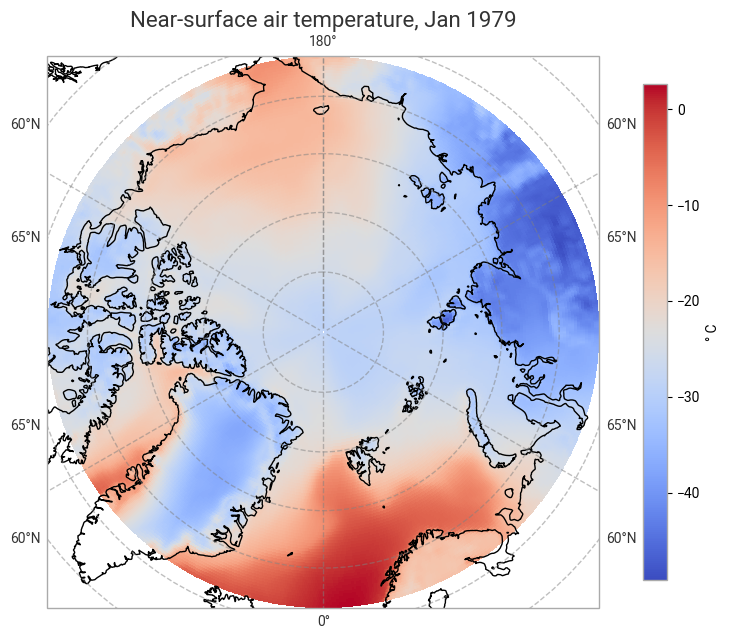

In [34]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8), subplot_kw={'projection': ccrs.Orthographic(central_latitude=90)})

im = ax.pcolormesh(Arc.longitude, Arc.latitude, Arc[0,:,:], transform = ccrs.PlateCarree(), cmap='coolwarm')
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_title('Near-surface air temperature, Jan 1979', fontsize=16)
ax.coastlines(color='black')

cbar = fig.colorbar(im, fraction=0.04, pad=0.07)
cbar.set_label('° C')

fig.savefig(f'{DATADIR}ERA5_Arctic_t2m_Jan1979.png')

### Aggregate over geographical lat/lon dimensions

We would like to analyse the time series of near-surface air temperature aggregated over the Arctic. To do this we need to average over the latitude and longitude dimensions. As before, we will need to take into account the varying size of the gridded data cells as a function of latitude.

In [35]:
weights = np.cos(np.deg2rad(Arc.latitude))
weights.name = "weights"
Arc_weighted = Arc.weighted(weights)
Arc_mean = Arc_weighted.mean(["longitude", "latitude"])

Let us create a simple plot of this data to see how it looks:

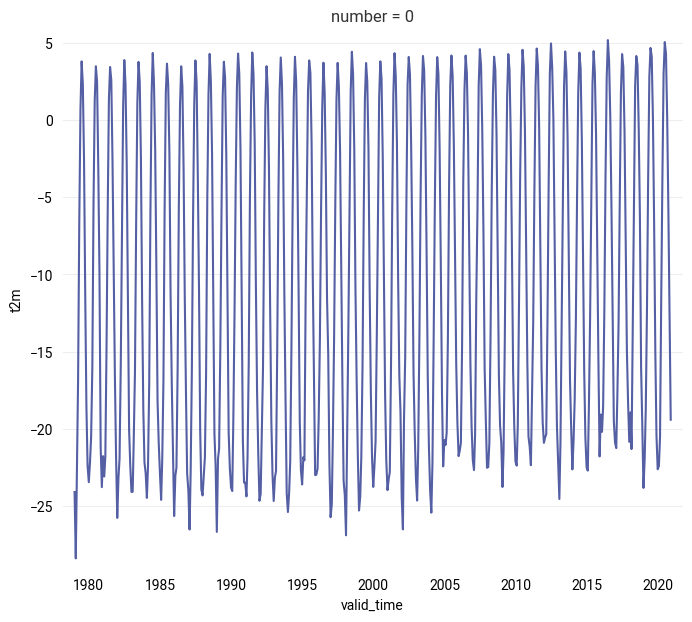

In [36]:
Arc_mean.plot()

Notice that the `plot()` function now creates a 2 dimensional graph of temperature as a function of time.

The trend in rising temperatures in the past decades is particularly noticable in the Arctic, and it is much easier to see this if we view the time series of yearly averages.

In [42]:
Arc_yearly = Arc_mean.groupby('valid_time.year').mean()

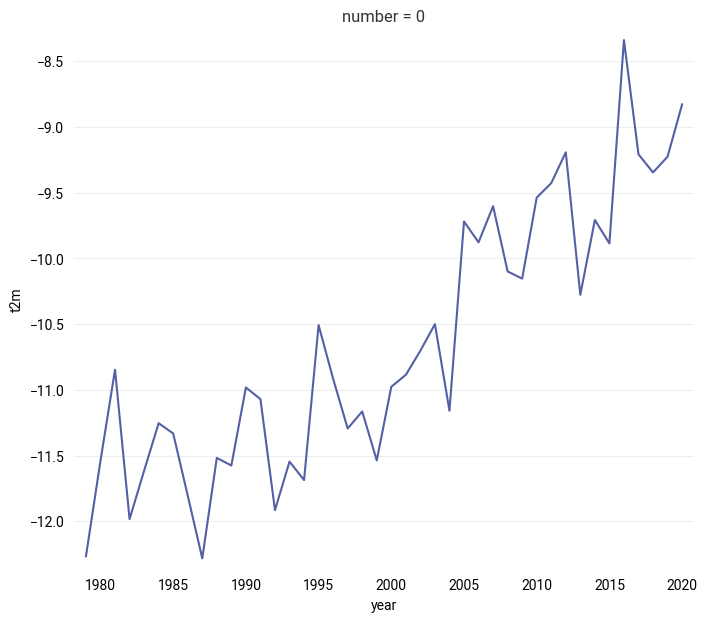

In [43]:
Arc_yearly.plot()

Here we can see a clear warming trend.

A typical way to view such a time series is to convert the absolute temperature values into anomalies with respect to a climate normal and view the time series as a bar chart. This can clearly highlight which years were on average warmer or cooler than the climate normal.

To do this, we calculate the anomalies with respect to a climate normal:

In [44]:
Arc_subset = Arc_yearly.where((Arc_yearly.year > 1990) & (Arc_yearly.year < 2021), drop=True)
Arc_clim = Arc_subset.mean()
Arc_anom = Arc_yearly - Arc_clim

We will now create a bar chart to visualize the time series of anomalies. We want to apply the color blue for years that are cooler than the reference period (negative anomalies) and the color red for years that are warmer than the reference period. For this, the next step is to convert the `xarray.DataArray` object into a `pandas.DataFrame` with the function `to_dataframe()`. Let us add an additional column called `positive`, indicating with a boolean value whether the air temperature anomaly is positive (`True`) or negative (`False`). The result is a data frame with 42 rows (one row per year) and two columns (`t2m`, `positive`).

In [45]:
df = Arc_anom.to_dataframe()
df['positive'] = df['t2m'] > 0
df.head() # show only first five rows

,number,t2m,positive
year,,,
1979,0,-1.990022,False
1980,0,-1.263204,False
1981,0,-0.570733,False
1982,0,-1.707727,False
1983,0,-1.338907,False


The `pandas.DataFrame` can then be visualized with the pandas built-in `plot()` function. You can customize the plot with the following keyword arguments:
* `figsize`: Define the size of the plot
* `kind`: Type of plot, e.g. `line`, `bar`, etc.
* `color`: color of the bars. With `df.positive.map()`, the colum `positive` is used to distinguish between bars that shall be colored in blue and bar that shall be colored in red
* `fontsize`: fontsize for x- and yticks
* `xlabel`, `ylabel`: Labels for x and y axes
* `title`: Title of the plot

See [here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html) a full list of possible keyword arguments.

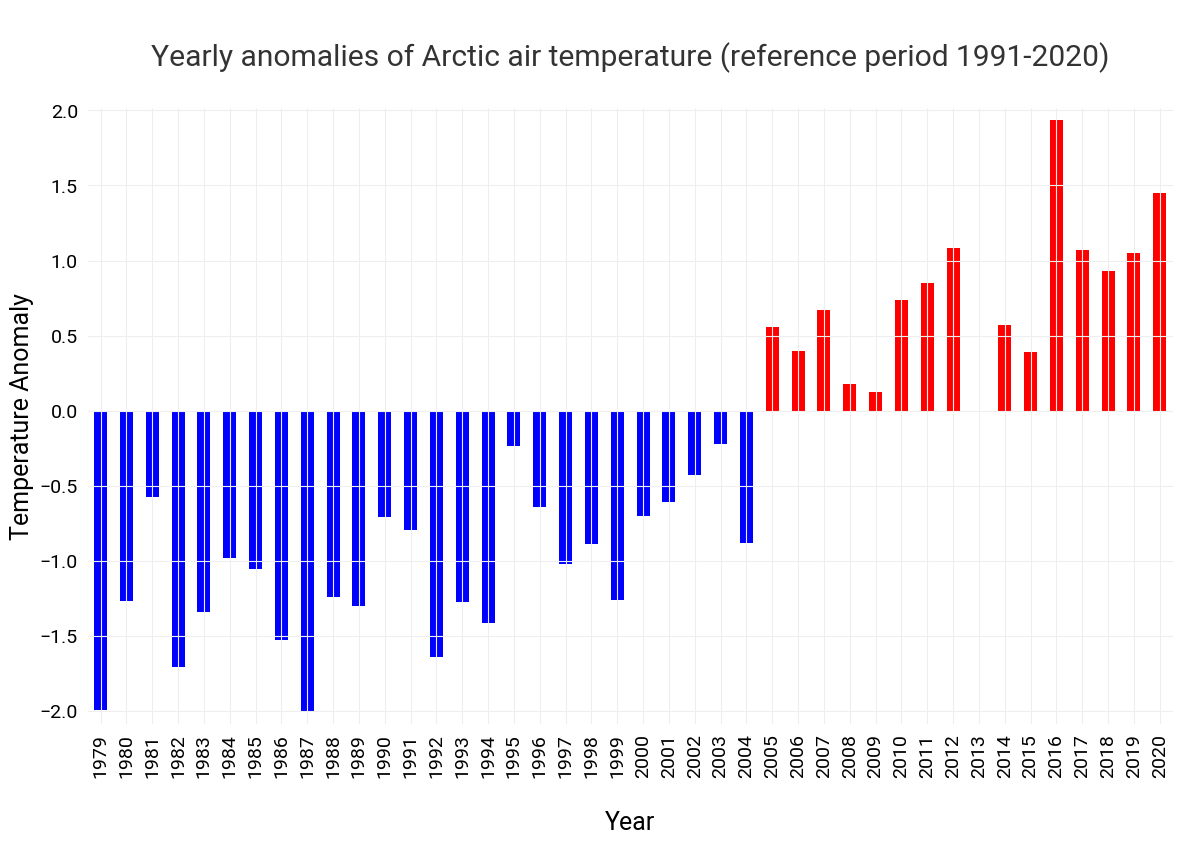

In [46]:
plt.rcParams.update({'font.size': 18}) # must set in top
df['t2m'].plot(
    figsize=(14,8),
    kind='bar',
    color=df.positive.map({True: 'red', False: 'blue'}),
    fontsize=14,
    xlabel='\nYear',
    ylabel='Temperature Anomaly',
    title='\nYearly anomalies of Arctic air temperature (reference period 1991-2020)\n',
    )
plt.savefig(f'{DATADIR}Arctic_t2m_anom_bar.png')

In the plot above, you see that since 2005, each year the Arctic near-surface air temperature was warmer than the reference mean for the period 1991-2020.

### Seasonal analysis of Arctic near-surface air temperature

In the final part of this tutorial we will compare seasonal trends in Arctic near-surface air temperature. To do this we return to our monthly geographically averaged dataset, and we will downsample the monthly averages to seasonal averages using the function `resample()`. By specifying `time='QS-DEC'`, the data is split into consecutive three-month periods, anchored at December. If we add additionally the function `mean()`, we calculate the average of the three-month period.

In [48]:
Arc_seasonal = Arc_mean.resample(valid_time='QS-DEC').mean()

In the code below, before visualising the seasonal average air temperature data for the Arctic, we create for each season (`winter`, `spring`, `summer` and `autumn`) a `pandas.DataFrame`. We then create a `for` loop to visualise each seasonal time series in a successive plot.

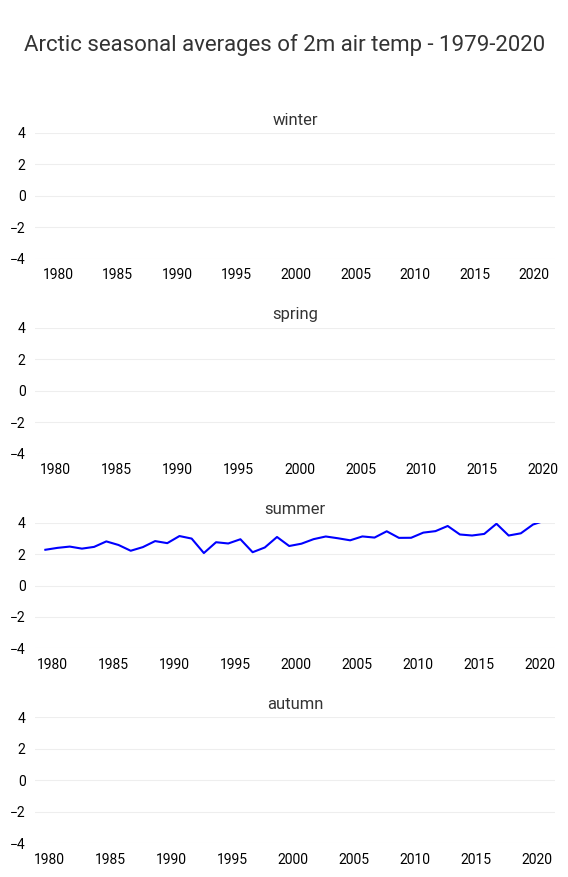

In [49]:
fig, axs = plt.subplots(4, 1, figsize = (6, 9))

season_list = ["winter", "spring", "summer", "autumn"]

for i in range(4):
    df = Arc_seasonal[i::4].to_dataframe()
    mid_range = np.around(df.mean().values)
    axs[i].plot(df.t2m, color='blue')
    axs[i].set_ylim([mid_range[0]-4, mid_range[0]+4])
    axs[i].set_title(season_list[i], fontsize=12)
    axs[i].tick_params(axis='x', labelsize=10)
    axs[i].tick_params(axis='y', labelsize=10)

fig.suptitle('\nArctic seasonal averages of 2m air temp - 1979-2020\n', fontsize=16)
fig.tight_layout(pad=1.0)

fig.savefig(f'{DATADIR}Arctic_seasonal.png')

Note the difference in variability of the seasonal average of air temperature in the Arctic: mean summer temperatures seem to be more constant compared to the other seasons.